<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Olivia/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

# Investigating and visualizing Mode Collapse in the MNIST dataset 

#What is mode collpase? 

mode collapse occurs when the generator is only generating a small  diversity of modes(digits).


#Why can it occur? 

 The generator learns to map several different input z values to the same output point. 

#How to identify mode collapse? 

Mode collapse can be identified by reviewing a large samples of generated images and looking for common signs of mode collapse:

   - low diversity of digits (reapting images of ones ) 

Looking at a line plot of the model loss in the generator: 
    - As the generator model is updated the loss should oscillate between different modes. 
    
#MNIST Dataset 
To visualize mode collapse in the MNIST dataset we will compare generated images from a gan model using a latent variable of 100 and a gan model using a latnet variable of 1. This is to restrict the size of the latent dimension to force the model to generate a small diversity of images. 
  

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Loading in the MNIST dataset


In [3]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [4]:
print(train_dataset.data.shape)

torch.Size([60000, 28, 28])


In [5]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [6]:
def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
        s=ax[i].imshow(np.squeeze(samples[i,]))
        s=ax[i].get_xaxis().set_visible(False)
        s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

In [7]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, input_size=28, base_size=128):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)           
    
    # forward method
    def forward(self, x): 
       # x = x.view(-1, self.input_size * self.input_size)
        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x



class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim, input_size=28, base_size=128):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size


        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )

        initialize_weights(self)

     # forward method
  def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

#Building a GAN model 

In [8]:
import matplotlib.gridspec as gridspec
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 128
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]



        # initialization of the generator and discriminator
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        
        # initialization of the loss function
        #self.BCE_loss = nn.SmoothL1Loss(beta=0.9)
        self.BCE_loss = nn.BCELoss().cuda()
        self.BCE_loss = nn.MSELoss()
        
        # Gettng a batch of noise to generate the fake data
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim)).cuda()
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):

       # Setting empty arrays for storing the losses

        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size,1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        # Epoch loops

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                # Generate random noise to push through the generator   

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()
               # x_ = x_.view(x_.size(0),-1)
                #z_ = z_.view(z_.size(0),-1)
                

         

                # update D network using 
                # 1. Set optimizer gradient to zero
                gan.D_optimizer.zero_grad()
                
                D_real = gan.D(x_)

                
                D_real_loss = gan.BCE_loss(D_real, gan.y_real_ )
                G_ = gan.G(z_)
                D_fake = gan.D(G_)
                D_fake_loss = gan.BCE_loss(D_fake, gan.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                # 3. Do back propagation to compute gradients
                D_loss.backward()
                # 4. Make a step of D_optimizer
                gan.D_optimizer.step()

                # 5. Set the current loss in self.train_hist['D_loss]
                gan.train_hist['D_loss'].append(D_loss.item())
                
                # update G network using 
                # 1. Set optimizer gradient to zero
                gan.G_optimizer.zero_grad()
                # 2. Set generator losses on fake data
                G_ = gan.G(z_)
                D_fake = gan.D(G_)
                G_loss = gan.BCE_loss(D_fake, gan.y_real_)
                # 3. Do back propagation to compute gradients
                G_loss.backward()
                # 4. Make a step of G_optimizer
                gan.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                gan.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses

                if ((iter + 1) % 50) == 0:
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
    
                  
            # Visualize results
            with torch.no_grad():
                 visualize_results(self)

        print('Generator Reconstruction Images Batch')
        visualise_output(self)
        digit_frequency(self)
        

        print("Training finished!")

In [9]:
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils

def visualise_output(gan):

    with torch.no_grad():
        sample_z_ = torch.rand((gan.base_size, gan.z_dim)).cuda()
        samples = gan.G(sample_z_)
        samples = samples.cpu()
        samples = (samples + 1) / 2
        np_imagegrid = torchvision.utils.make_grid(samples[1:50], 10, 5).detach().numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

def digit_frequency(gan): 
  z = torch.rand((gan.base_size, gan.z_dim)).cuda()
  z = gan.G(z)
  z = z.cpu()
  unique, counts = np.unique(z.detach().numpy(), return_counts=True)
  plt.bar(unique, counts)
  plt.xticks(unique)
  plt.xlabel("Label")
  plt.ylabel("Quantity")
  plt.title("Labels in MNIST 784 dataset")
  


  



# Training Gan with a latent dimension of 100

training start!!
Epoch: [ 1] [  50/ 468] D_loss: 0.21215773, G_loss: 0.48357069
Epoch: [ 1] [ 100/ 468] D_loss: 0.26176092, G_loss: 0.47335017
Epoch: [ 1] [ 150/ 468] D_loss: 0.24681652, G_loss: 0.54090792
Epoch: [ 1] [ 200/ 468] D_loss: 0.22882156, G_loss: 0.51683295
Epoch: [ 1] [ 250/ 468] D_loss: 0.27241799, G_loss: 0.46548924
Epoch: [ 1] [ 300/ 468] D_loss: 0.35295683, G_loss: 0.52978808
Epoch: [ 1] [ 350/ 468] D_loss: 0.28298107, G_loss: 0.50340950
Epoch: [ 1] [ 400/ 468] D_loss: 0.29034793, G_loss: 0.43942088
Epoch: [ 1] [ 450/ 468] D_loss: 0.24352635, G_loss: 0.48568526


<Figure size 72x720 with 0 Axes>

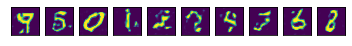

Generator Reconstruction Images Batch


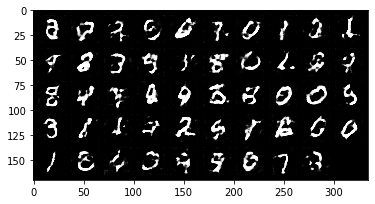

Training finished!
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f9c2e922d40> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f9c2e8ae3b0> (for post_execute):


KeyboardInterrupt: ignored

In [10]:
import time
params = {'beta1': 0.05, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':1}
params['z_dim'] =100
params['base_size'] = 128

gan = GAN(params)
gan.train()